# Library

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 

import numpy as np
seed = 0
np.random.seed(seed)

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import re
import string

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
import json, os, uuid

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# EDA

In [2]:
reviews_df = pd.read_csv('Scrap_Reviews.csv')
reviews_df = pd.DataFrame(reviews_df)

In [3]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  94130 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          16438 non-null   object
 9   repliedAt             16438 non-null   object
 10  appVersion            94130 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [4]:
unnecessary_columns = [
 'userName', 
 'userImage', 
 'thumbsUpCount', 
 'reviewCreatedVersion',
 'at',
 'replyContent',
 'repliedAt',
 'appVersion'
]

In [5]:
reviews_df = reviews_df.drop(columns=unnecessary_columns)
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   reviewId  103500 non-null  object
 1   content   103500 non-null  object
 2   score     103500 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.4+ MB


In [6]:
reviews_df.head()

,reviewId,content,score
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1


In [7]:
print('Number of duplicated data:', reviews_df.duplicated().sum())

Number of duplicated data: 0


# Preprocessing

## Create Function

In [8]:
def cleaning_Text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Deleting '@' within text
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # Deleting '#' within text
    text = re.sub(r'RT[\s]', '', text) # Deleting RT
    text = re.sub(r"http\s+", '', text) # Deleting url link
    text = re.sub(r'[0-9]+', '', text) # Deleting Number
    text = re.sub(r'[^\w\s]', '', text) # Deleting Unique Character

    text = text.replace('\n', '')
    text = text.translate(str.maketrans('', '', string.punctuation)) # Deleting punctuation
    text = text.strip(' ')
    return text

def casefolding_Text(text):
    text = text.lower()
    return text

def tokenizing_Text(text):
    text = word_tokenize(text)
    return text

def filtering_Text(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'])
    
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    
    text = filtered
    return text

def stemming_Text(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text):
    slangwords = {
        '@': 'di',
        'abis': 'habis',
        'wtb': 'beli',
        'wts': 'jual',
        'wtt': 'tukar',
        'masi': 'masih',
        'bgt': 'banget',
        'maks': 'maksimal',
        'min': 'minimal',
        'mantab': 'mantap',
        'ga': 'tidak',
        'kasi': 'kasih'
    }

    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text


## Text Cleaning

In [9]:
reviews_df['text_clean'] = reviews_df['content'].apply(cleaning_Text)
 
reviews_df['text_casefolding_Text'] = reviews_df['text_clean'].apply(casefolding_Text)
 
reviews_df['text_slangwords'] = reviews_df['text_casefolding_Text'].apply(fix_slangwords)
 
reviews_df['text_tokenizing_Text'] = reviews_df['text_slangwords'].apply(tokenizing_Text)
 
reviews_df['text_stopword'] = reviews_df['text_tokenizing_Text'].apply(filtering_Text)
 
reviews_df['text_akhir'] = reviews_df['text_stopword'].apply(toSentence)

In [10]:
reviews_df

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5,Dompet digital andalan Transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,"[dompet, digital, andalan, transaksi, jadi, su...","[dompet, digital, andalan, transaksi, super, m...",dompet digital andalan transaksi super mudah c...
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4,Tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,"[tolong, beri, fitur, untuk, dapat, berkomunik...","[tolong, fitur, berkomunikasi, costumer, servi...",tolong fitur berkomunikasi costumer service ag...
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1,Sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,"[sangat, kecewa, dengan, aplikasi, ini, tidak,...","[kecewa, aplikasi, transfer, bank, lancar, tdk...",kecewa aplikasi transfer bank lancar tdk trans...
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5,Oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,"[oke, banget, aplikasi, ini, semua, fungsi, e,...","[oke, banget, aplikasi, fungsi, e, banking, tr...",oke banget aplikasi fungsi e banking transfer ...
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1,Gopay Later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,"[gopay, later, dulu, tahun, an, sering, pake, ...","[gopay, later, pake, topup, pulsa, bayar, game...",gopay later pake topup pulsa bayar game dll ma...
...,...,...,...,...,...,...,...,...,...
103495,5f6d12b7-66c2-4436-bbdf-bdc64dae8aa7,Puas,5,Puas,puas,puas,[puas],[puas],puas
103496,cb1c89e0-27a1-423c-81d5-c490fac9c16c,good,5,good,good,good,[good],[good],good
103497,de6e9abc-79e1-4470-976c-c31429b4b369,Mantap,5,Mantap,mantap,mantap,[mantap],[mantap],mantap
103498,1db1b461-9b85-48d2-a5e2-20227e11e80a,Mantppp,5,Mantppp,mantppp,mantppp,[mantppp],[mantppp],mantppp


## Labeling

In [11]:
import csv
import requests
from io import StringIO

### Get Dictionary

In [12]:
# Positive Dict
lexicon_positive = dict()
response_plus = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

if response_plus.status_code == 200:
    reader_plus = csv.reader(StringIO(response_plus.text), delimiter=',')

    for row in reader_plus:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")


In [13]:
# Negative Dict
lexicon_negative = dict()
response_min = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response_min.status_code == 200:
    reader_min = csv.reader(StringIO(response_min.text), delimiter=',')
    
    for row in reader_min:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

### Sentiment Checking

In [14]:
def sa_lexicon_indonesia(text):
    score_positive = 0

    for word in text:
        if (word in lexicon_positive):
            score_positive += lexicon_positive[word]
    
    score_negative = 0

    for word in text:
        if (word in lexicon_negative):
            score_negative += lexicon_negative[word]

    total_score = score_positive + score_negative

    polarity = ''

    if (total_score > 0):
        polarity = 'positive'
    elif (total_score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    
    return total_score, polarity

In [15]:
polarity = reviews_df['text_stopword'].apply(sa_lexicon_indonesia)
polarity = list(zip(*polarity))

reviews_df['sentiment_score'] = polarity[0]
reviews_df['sentiment'] = polarity[1]

In [16]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   reviewId               103500 non-null  object
 1   content                103500 non-null  object
 2   score                  103500 non-null  int64 
 3   text_clean             103500 non-null  object
 4   text_casefolding_Text  103500 non-null  object
 5   text_slangwords        103500 non-null  object
 6   text_tokenizing_Text   103500 non-null  object
 7   text_stopword          103500 non-null  object
 8   text_akhir             103500 non-null  object
 9   sentiment_score        103500 non-null  int64 
 10  sentiment              103500 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [17]:
reviews_df.sort_index()

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment
0,ca90fa27-ee72-4580-90c6-78d4e72e5894,Dompet digital andalan! Transaksi jadi super m...,5,Dompet digital andalan Transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,dompet digital andalan transaksi jadi super mu...,"[dompet, digital, andalan, transaksi, jadi, su...","[dompet, digital, andalan, transaksi, super, m...",dompet digital andalan transaksi super mudah c...,11,positive
1,d776443f-32cd-4e52-9bca-7406e994b74f,Tolong beri fitur untuk dapat berkomunikasi de...,4,Tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,tolong beri fitur untuk dapat berkomunikasi de...,"[tolong, beri, fitur, untuk, dapat, berkomunik...","[tolong, fitur, berkomunikasi, costumer, servi...",tolong fitur berkomunikasi costumer service ag...,-14,negative
2,b8254684-1c3b-41ae-b0a3-514fb7b505af,"Sangat kecewa dengan aplikasi ini, tidak bisa ...",1,Sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,sangat kecewa dengan aplikasi ini tidak bisa u...,"[sangat, kecewa, dengan, aplikasi, ini, tidak,...","[kecewa, aplikasi, transfer, bank, lancar, tdk...",kecewa aplikasi transfer bank lancar tdk trans...,-6,negative
3,19273dbc-eb8c-4ef7-9bbc-f619d20dd866,"Oke banget aplikasi ini, semua fungsi e bankin...",5,Oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,oke banget aplikasi ini semua fungsi e banking...,"[oke, banget, aplikasi, ini, semua, fungsi, e,...","[oke, banget, aplikasi, fungsi, e, banking, tr...",oke banget aplikasi fungsi e banking transfer ...,4,positive
4,9833a561-f6b0-44f1-9d00-b223c149eaee,Gopay Later dulu tahun 2018an sering pake buat...,1,Gopay Later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,gopay later dulu tahun an sering pake buat top...,"[gopay, later, dulu, tahun, an, sering, pake, ...","[gopay, later, pake, topup, pulsa, bayar, game...",gopay later pake topup pulsa bayar game dll ma...,-12,negative
...,...,...,...,...,...,...,...,...,...,...,...
103495,5f6d12b7-66c2-4436-bbdf-bdc64dae8aa7,Puas,5,Puas,puas,puas,[puas],[puas],puas,3,positive
103496,cb1c89e0-27a1-423c-81d5-c490fac9c16c,good,5,good,good,good,[good],[good],good,5,positive
103497,de6e9abc-79e1-4470-976c-c31429b4b369,Mantap,5,Mantap,mantap,mantap,[mantap],[mantap],mantap,5,positive
103498,1db1b461-9b85-48d2-a5e2-20227e11e80a,Mantppp,5,Mantppp,mantppp,mantppp,[mantppp],[mantppp],mantppp,0,neutral


In [18]:
reviews_df['sentiment'].value_counts()

sentiment
positive    52412
negative    26923
neutral     24165
Name: count, dtype: int64

### Downsampling

In [19]:
from sklearn.utils import shuffle

In [20]:
positive_samples = reviews_df[reviews_df['sentiment'] == 'positive']
negative_samples = reviews_df[reviews_df['sentiment'] == 'negative']
neutral_samples = reviews_df[reviews_df['sentiment'] == 'neutral']

In [21]:
min_size = min(len(positive_samples), len(negative_samples), len(neutral_samples))

In [22]:
positive_downsampled = positive_samples.sample(min_size, random_state=42)
negative_downsampled = negative_samples.sample(min_size, random_state=42)
neutral_downsampled = neutral_samples.sample(min_size, random_state=42)

In [23]:
balanced_df = pd.concat([positive_downsampled, negative_downsampled, neutral_downsampled])

In [24]:
balanced_df = shuffle(balanced_df, random_state=42)
balanced_df.head()

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment
45761,8de2eaf2-eb01-4f55-b2da-dd6471f64514,Gopay mantul pendaftaran gk ribet. Menu yg ada...,5,Gopay mantul pendaftaran gk ribet Menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,"[gopay, mantul, pendaftaran, gk, ribet, menu, ...","[gopay, mantul, pendaftaran, gk, ribet, menu, ...",gopay mantul pendaftaran gk ribet menu yg gopa...,-9,negative
20279,0ae1c9d9-f48d-4418-b87f-a568cebc738b,Gak nyesel udh download GoPay Transfer.. Setia...,5,Gak nyesel udh download GoPay Transfer Setiap ...,gak nyesel udh download gopay transfer setiap ...,gak nyesel udh download gopay transfer setiap ...,"[gak, nyesel, udh, download, gopay, transfer, ...","[nyesel, udh, download, gopay, transfer, mo, t...",nyesel udh download gopay transfer mo tf bank ...,-4,negative
35116,a825dbfd-3bb6-4dad-9c9c-06c751e91d13,Puas dengan segala pelayanannya dalam bertrans...,5,Puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,"[puas, dengan, segala, pelayanannya, dalam, be...","[puas, pelayanannya, bertransaksi, jaman, ribet]",puas pelayanannya bertransaksi jaman ribet,0,neutral
40709,ae1011ee-f06a-4372-b8cd-e998113b7170,Susah update berkas nya aga ribet nelp call ce...,1,Susah update berkas nya aga ribet nelp call ce...,susah update berkas nya aga ribet nelp call ce...,susah update berkas nya aga ribet nelp call ce...,"[susah, update, berkas, nya, aga, ribet, nelp,...","[susah, update, berkas, aga, ribet, nelp, call...",susah update berkas aga ribet nelp call centernya,-7,negative
21646,93b5aeb0-5122-4940-93ba-d5a27103969f,sangat membantu,5,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],membantu,0,neutral


In [25]:
balanced_df['sentiment'].value_counts()

sentiment
negative    24165
neutral     24165
positive    24165
Name: count, dtype: int64

In [26]:
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
balanced_df['sentiment_class'] = balanced_df['sentiment'].map(sentiment_mapping)

In [27]:
balanced_df['sentiment_class'].value_counts()

sentiment_class
0    24165
1    24165
2    24165
Name: count, dtype: int64

In [28]:
balanced_df.head(3)

,reviewId,content,score,text_clean,text_casefolding_Text,text_slangwords,text_tokenizing_Text,text_stopword,text_akhir,sentiment_score,sentiment,sentiment_class
45761,8de2eaf2-eb01-4f55-b2da-dd6471f64514,Gopay mantul pendaftaran gk ribet. Menu yg ada...,5,Gopay mantul pendaftaran gk ribet Menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,gopay mantul pendaftaran gk ribet menu yg ada ...,"[gopay, mantul, pendaftaran, gk, ribet, menu, ...","[gopay, mantul, pendaftaran, gk, ribet, menu, ...",gopay mantul pendaftaran gk ribet menu yg gopa...,-9,negative,0
20279,0ae1c9d9-f48d-4418-b87f-a568cebc738b,Gak nyesel udh download GoPay Transfer.. Setia...,5,Gak nyesel udh download GoPay Transfer Setiap ...,gak nyesel udh download gopay transfer setiap ...,gak nyesel udh download gopay transfer setiap ...,"[gak, nyesel, udh, download, gopay, transfer, ...","[nyesel, udh, download, gopay, transfer, mo, t...",nyesel udh download gopay transfer mo tf bank ...,-4,negative,0
35116,a825dbfd-3bb6-4dad-9c9c-06c751e91d13,Puas dengan segala pelayanannya dalam bertrans...,5,Puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,puas dengan segala pelayanannya dalam bertrans...,"[puas, dengan, segala, pelayanannya, dalam, be...","[puas, pelayanannya, bertransaksi, jaman, ribet]",puas pelayanannya bertransaksi jaman ribet,0,neutral,1


## Split Data

In [29]:
# Feature
X = balanced_df['text_akhir']

# Label
y = balanced_df['sentiment_class']

In [30]:
# Check
y

45761    0
20279    0
35116    1
40709    0
21646    1
        ..
64855    0
61261    2
10517    1
44296    2
92486    2
Name: sentiment_class, Length: 72495, dtype: int64

In [31]:
TEST_SIZE_10 = 0.1 # untuk Model 1

TEST_SIZE_30 = 0.3 # untuk Model 3

In [32]:
# Train Split Function
def train_split(X, y, TEST_SIZE):
    X_train, X_temp, y_train, y_temp = train_test_split(X,
                                                    y,
                                                    test_size=TEST_SIZE,
                                                    random_state=42
                                    )
    
    X_val, X_test, y_val, y_test = train_test_split(X_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=42
                                    )
    return X_train, X_val, X_test, y_train, y_val, y_test

In [33]:
# Split 1
X_train_1, X_val_1, X_test_1, y_train_1, y_val_1, y_test_1 = train_split(X, y, TEST_SIZE_10)

# Split 3
X_train_3, X_val_3, X_test_3, y_train_3, y_val_3, y_test_3 = train_split(X, y, TEST_SIZE_30)

## Feature Extraction

### TF-IDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
tfidf = TfidfVectorizer(
    max_features=200,
    min_df=17,
    max_df=0.8
)

## Data Preparation

### TFIDF Scenario

#### Train Data

In [36]:
from sklearn.manifold import TSNE

In [37]:
tfidf.fit(X_train_1)

X_tfidf_train = tfidf.transform(X_train_1)
X_tfidf_val = tfidf.transform(X_val_1)
X_tfidf_test = tfidf.transform(X_test_1)

In [38]:
X_tfidf_train = X_tfidf_train.toarray()
X_tfidf_val = X_tfidf_val.toarray()

In [39]:
X_tfidf_train_df = pd.DataFrame(X_tfidf_train, columns=tfidf.get_feature_names_out())
X_tfidf_train_df

,admin,aja,akun,aman,aneh,apapun,apk,aplikasi,aplikasinya,app,...,transfer,trus,tunai,uang,udah,udh,update,upgrade,utk,yg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.602535,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
65241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.702462,0.0
65242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
65243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534461,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [40]:
X_tfidf_train_df.describe().T.sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
gitu,65245.0,0.001404,0.026041,0.0,0.0,0.0,0.0,1.0
kena,65245.0,0.001460,0.027186,0.0,0.0,0.0,0.0,1.0
sampe,65245.0,0.001488,0.026563,0.0,0.0,0.0,0.0,1.0
suruh,65245.0,0.001528,0.026250,0.0,0.0,0.0,0.0,1.0
muncul,65245.0,0.001559,0.029892,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
aplikasi,65245.0,0.047307,0.149429,0.0,0.0,0.0,0.0,1.0
gopay,65245.0,0.053648,0.152514,0.0,0.0,0.0,0.0,1.0
mantap,65245.0,0.058391,0.217919,0.0,0.0,0.0,0.0,1.0
membantu,65245.0,0.068092,0.228248,0.0,0.0,0.0,0.0,1.0


### RNN Scenario

In [64]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#### Train Data

In [42]:
X_nn_train = X_train_3

tokenizer = Tokenizer(num_words=10_000)
tokenizer.fit_on_texts(X_nn_train)
word_index = tokenizer.word_index

X_rnn = tokenizer.texts_to_sequences(X_nn_train)
X_rnn = pad_sequences(X_rnn, maxlen=100)

In [65]:
encoder = LabelEncoder()
y_rnn_train = encoder.fit_transform(y_train_3)
y_rnn_train = to_categorical(y_rnn_train)

#### Validation Data

In [66]:
X_nn_val = X_val_3

X_rnn_val = tokenizer.texts_to_sequences(X_nn_val)
X_rnn_val = pad_sequences(X_rnn_val, maxlen=100)

In [67]:
encoder = LabelEncoder()
y_rnn_val = encoder.fit_transform(y_val_3)
y_rnn_val = to_categorical(y_rnn_val)

# Modeling

## SVM Model for TFIDF Scenario

### Training

In [44]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [45]:
# X_train = X_tfidf_train
# X_val = X_tfidf_val
# y_train = y_train_1
# y_val = y_val_1

In [46]:
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')

In [47]:
svm_model.fit(X_tfidf_train, y_train_1)

SVC()

### Evaluation

Accuracy SVM: 0.90

Classification Report SVM:
               precision    recall  f1-score   support

    negative       0.90      0.90      0.90      1231
     neutral       0.88      0.92      0.90      1174
    positive       0.93      0.88      0.91      1220

    accuracy                           0.90      3625
   macro avg       0.90      0.90      0.90      3625
weighted avg       0.90      0.90      0.90      3625

Confusion Matrix SVM:
 [[1111   74   46]
 [  64 1080   30]
 [  65   77 1078]]


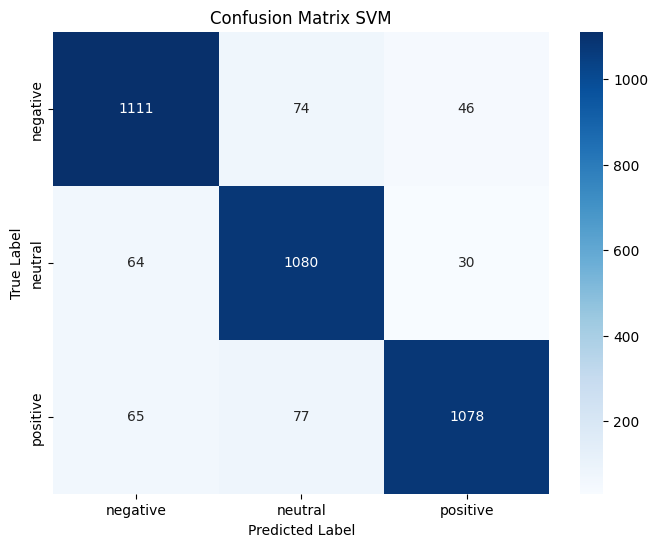

In [48]:
y_pred_svm = svm_model.predict(X_tfidf_val)

# Akurasi
accuracy_svm = accuracy_score(y_val_1, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:.2f}")

# Report
report_svm = classification_report(y_val_1, y_pred_svm, target_names=['negative', 'neutral', 'positive'])
print("\nClassification Report SVM:\n", report_svm)

# Confusion Matrix
conf_matrix_svm = confusion_matrix(y_val_1, y_pred_svm)
print("Confusion Matrix SVM:\n", conf_matrix_svm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.show()

### Model Testing

In [49]:
X_Inference_1 = balanced_df['content']
y_Inference_1 = balanced_df['sentiment_class']

In [50]:
X_Train_1, X_Test_1, y_Train_1, y_Test_1 = train_test_split(X_Inference_1, y_Inference_1, test_size=0.05, random_state=42, shuffle=True)

In [51]:
X_Test_1.shape

(3625,)

In [52]:
X_Test_1_df = pd.DataFrame(X_Test_1)
X_Test_1_df

,content
23157,Sangat menyenangkan menggunakan GoPay
71396,Mantap
37219,suka repot kalau disuruh emak isi token listri...
97480,mantap
73004,Sangat bagusssssss
...,...
39863,"Bagus Sekali, Dengan Gopay Semua Transaksi Jdi..."
35831,sangat membantu
11148,"Aplikasinya mudah dipake, fiturnya ada isi pul..."
75852,bagus aplikasi ya bayar apa aja gampang buat k...


In [53]:
X_tfidf_Inference = tfidf.fit_transform(X_Test_1)

In [54]:
X_tfidf_Inference.shape

(3625, 200)

In [55]:
X_tfidf_Inference = X_tfidf_Inference.toarray()

In [56]:
X_tfidf_Inference_df = pd.DataFrame(X_tfidf_Inference, columns=tfidf.get_feature_names_out())
X_tfidf_Inference_df

,ada,admin,aja,aku,akun,aman,apa,apapun,apk,aplikasi,...,uang,udah,udh,untuk,up,upgrade,wallet,ya,yang,yg
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.000000,0.0,0.289723,0.0,0.0,0.0,0.00000,0.0,0.276054,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3620,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3621,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0
3622,0.155656,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.000000,0.252229,...,0.0,0.0,0.0,0.17071,0.0,0.0,0.0,0.00000,0.0,0.0
3623,0.000000,0.0,0.256737,0.0,0.0,0.0,0.28562,0.0,0.000000,0.173371,...,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.26331,0.0,0.0


In [57]:
predictions_svm_1 = svm_model.predict(X_tfidf_Inference)

labeling_1 = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
predictions_svm_labels_1 = [labeling_1[pred] for pred in predictions_svm_1]

In [58]:
results_svm_1 = pd.DataFrame({
    'Review': X_Test_1,
    'Sentiment': predictions_svm_labels_1
})
results_svm_1.to_csv('results_svm', index=True)
results_svm_1['Sentiment'].value_counts()

Sentiment
Negative    1611
Positive    1172
Neutral      842
Name: count, dtype: int64

In [59]:
results_svm_1.sort_index()

,Review,Sentiment
32,"saya mau transfer saldo gopay ke rekening, ket...",Negative
62,"Tolong dong user lama lebih di perhatikan,masa...",Positive
183,Performa aplikasi cukup baik tapi tolong dirin...,Positive
192,"Gila sih, udah upgrade gopay plus keamanan 100...",Negative
235,Beli token listrik di gopay keterangan sudah s...,Positive
...,...,...
103399,Ok,Positive
103435,Bagus,Negative
103444,Ok,Positive
103452,Terbaik,Neutral


## RNN Model

### Training

In [68]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping 
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [69]:
# Checkpoint
class checkpoint(Callback):
    def __init__(self):
        super().__init__()
        self.best_accuracy = 0.92
    
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') > self.best_accuracy:
            print(f"\nEpoch {epoch + 1}: val_accuracy is above 92%")

In [70]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10_000, output_dim=128, input_length=100),
    tf.keras.layers.GRU(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,317,443
Trainable params: 1,317,443
Non-trainable params: 0
_________________________________________________________________


In [71]:
EPOCHS = 5
BATCH = 128

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = checkpoint()

history_3 = model_3.fit(
    X_rnn,
    y_rnn_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_rnn_val, y_rnn_val),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
397/397 [==============================] - ETA: 0s - loss: 0.3549 - accuracy: 0.8646
Epoch 1: val_accuracy is above 92%
397/397 [==============================] - 58s 139ms/step - loss: 0.3549 - accuracy: 0.8646 - val_loss: 0.1758 - val_accuracy: 0.9390
Epoch 2/5
397/397 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9580
Epoch 2: val_accuracy is above 92%
397/397 [==============================] - 97s 245ms/step - loss: 0.1185 - accuracy: 0.9580 - val_loss: 0.1458 - val_accuracy: 0.9484
Epoch 3/5
397/397 [==============================] - ETA: 0s - loss: 0.0753 - accuracy: 0.9739
Epoch 3: val_accuracy is above 92%
397/397 [==============================] - 128s 322ms/step - loss: 0.0753 - accuracy: 0.9739 - val_loss: 0.1496 - val_accuracy: 0.9502
Epoch 4/5
397/397 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9792
Epoch 4: val_accuracy is above 92%
397/397 [==============================] - 142s 358ms/step - loss: 0.0599 - a

### Evaluation

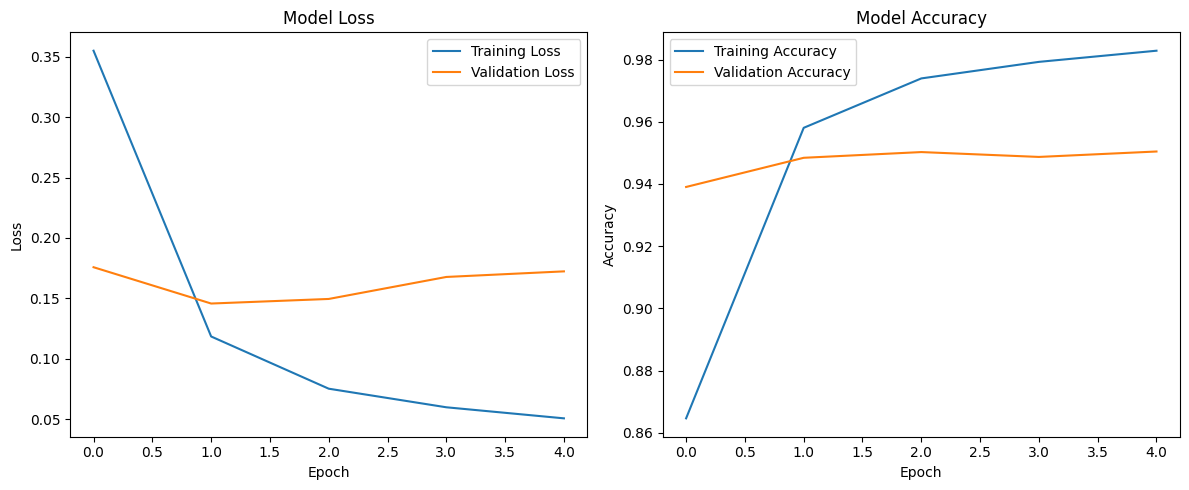

In [72]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_3.history['loss'], label='Training Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history_3.history['accuracy'], label='Training Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [73]:
# Save Model
save_dir = r'D:\2. Self Dev & Goals\3. Upgrading Skills\Dicoding\1. ML - Intermediate Level'
model_path = os.path.join(save_dir, 'model_3')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_3.save(model_path)

INFO:tensorflow:Assets written to: D:\2. Self Dev & Goals\3. Upgrading Skills\Dicoding\1. ML - Intermediate Level\model_3\assets


### Model Testing

In [74]:
X_Inference_3 = balanced_df['content']
y_Inference_3 = balanced_df['sentiment_class']

In [75]:
X_Train_3, X_Test_3, y_Train_3, y_Test_3 = train_test_split(X_Inference_3, y_Inference_3, test_size=0.15, random_state=42, shuffle=True)

In [76]:
X_Test_3.shape

(10875,)

In [77]:
X_Test_3_df = pd.DataFrame(X_Test_3)
X_Test_3_df

,content
23157,Sangat menyenangkan menggunakan GoPay
71396,Mantap
37219,suka repot kalau disuruh emak isi token listri...
97480,mantap
73004,Sangat bagusssssss
...,...
73061,mantap...
25058,Apknya sangat membantu sekali untuk keseharian...
21894,sangat membantu
70514,Mantap


In [84]:
from tensorflow.keras.models import load_model

model_rnn = load_model(model_path)

In [81]:
tokenizer.fit_on_texts(X_Test_3)

In [82]:
sequence_inf = tokenizer.texts_to_sequences(X_Test_3)

In [83]:
max_length = 100

padded_sequences_inf = pad_sequences(sequence_inf, maxlen=max_length)

In [85]:
predict_inf = model_rnn.predict(padded_sequences_inf)

340/340 [==============================] - 8s 22ms/step


In [86]:
predicted_classes = predict_inf.argmax(axis=-1)

In [87]:
predicted_classes

array([2, 2, 0, ..., 2, 2, 2], dtype=int64)

In [91]:
results_rnn = pd.DataFrame({
    'Review': X_Test_3,
    'Sentiment_Class': predicted_classes
})

results_rnn['Sentiment_Class'].value_counts()

Sentiment_Class
2    4789
0    3850
1    2236
Name: count, dtype: int64

In [93]:
labels_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
results_rnn['Sentiment'] = results_rnn['Sentiment_Class'].map(labels_mapping)

In [95]:
results_rnn.sort_index()

,Review,Sentiment_Class,Sentiment
0,Dompet digital andalan! Transaksi jadi super m...,0,negative
1,Tolong beri fitur untuk dapat berkomunikasi de...,0,negative
3,"Oke banget aplikasi ini, semua fungsi e bankin...",0,negative
21,Saya tidak tahu apa penyebab nya gopay tidak b...,2,positive
22,"tolong min, kenapa pembayaran QRIS ataupun man...",0,negative
...,...,...,...
103444,Ok,0,negative
103445,Jessymaudy,1,neutral
103452,Terbaik,0,negative
103465,Ok,0,negative


In [96]:
results_rnn.to_csv('results_rnn', index=True)

# Requirement.txt

In [97]:
!pip freeze > requirements.txt